In [4]:
import numpy as np
import pandas as pd
from scipy.stats import rankdata
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from copy import copy

In [ ]:
def f1(u):
    x, y = u
    return x**2 + y**2

def f2(u,p1=1,p2=1):
    x, y = u
    return (x - p1)**2 + (y + p2)**2  

def objectives(u, p1=1, p2=1):
    x, y = u
    f1 = x**2 + y**2  
    f2 = (x - p1)**2 + (y + p2)**2  
    return np.array([f1, f2])

def generate_elliptical_points(center, axes, num_points, angle=0):
    # Generate random angles and radii
    theta = np.random.uniform(0, 2 * np.pi, num_points)
    r = np.random.uniform(0, 1, num_points)

    # Transform to elliptical radii
    x = axes[0] * r * np.cos(theta)
    y = axes[1] * r * np.sin(theta)

    # Rotate points by the given angle
    angle_rad = np.radians(angle)
    x_rot = x * np.cos(angle_rad) - y * np.sin(angle_rad)
    y_rot = x * np.sin(angle_rad) + y * np.cos(angle_rad)

    # Translate to the ellipse center
    x_final = x_rot + center[0]
    y_final = y_rot + center[1]

    return np.column_stack((x_final, y_final))

# Topsis – wariant ciągły: Fuzzy Topsis, Przykłady obliczeń z U⊂R4 i N=4

Najlepszy możliwy punkt: [1.02030405e-04 6.61157025e-05]
Najgorszy możliwy punkt: [1. 1.]
Najlepszy punkt zbioru: [0.00457116 0.00433997], Ranking: 0.9956270551200029


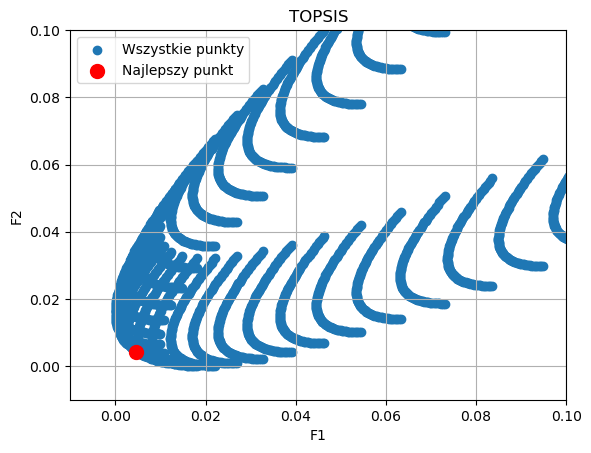

In [14]:
x_vals = np.linspace(-10, 10, 100)
y_vals = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_vals, y_vals)
U_grid = np.column_stack([X.ravel(), Y.ravel()])
data = np.array([objectives(p, 1, 1) for p in U_grid])

# Normalizacja
m = len(data) # Liczba punktów
n = len(data[0]) # Liczba kryteriów
divisors = np.empty(n)
for j in range(n):
    column = data[:,j]
    divisors[j] = np.linalg.norm(column, ord=np.inf)
data /= divisors

# pareto = pareto_front(data)

# Wyznaczanie najlepszego i najgorszego możliwego punktu
a_pos = np.zeros(n)
a_neg = np.zeros(n)
for j in range(n):
    column = data[:,j]
    a_pos[j] = np.min(column) # Minimalizujemy więc im mniej tym lepiej
    a_neg[j] = np.max(column)

print(f"Najlepszy możliwy punkt: {a_pos}")
print(f"Najgorszy możliwy punkt: {a_neg}")

# Wyznaczanie dystansów i rankingu
cs = np.zeros(m)
for i in range(m):
    diff_pos = data[i] - a_pos
    diff_neg = data[i] - a_neg
    sp = np.sqrt(diff_pos @ diff_pos)
    sn = np.sqrt(diff_neg @ diff_neg)
    cs[i] = sn / (sp + sn)

cs_best = max(cs)
best_point_index = list(cs).index(cs_best)
best_point = data[best_point_index]

print(f"Najlepszy punkt zbioru: {best_point}, Ranking: {cs_best}")

plt.scatter(data[:, 0], data[:, 1], label="Wszystkie punkty")
# plt.scatter(pareto[:, 0], pareto[:, 1], color='orange', label="Punkty Pareto")
plt.scatter(best_point[0], best_point[1], color='red', label="Najlepszy punkt", s=100)

plt.title("TOPSIS")
plt.xlim([-0.01, 0.1])
plt.ylim([-0.01, 0.1])
plt.xlabel("F1")
plt.ylabel("F2")
plt.legend()
plt.grid()

In [54]:
import plotly.express as px
import plotly.graph_objs as go
from sklearn.decomposition import PCA
import numpy as np

class FuzzyNumber:
    def __init__(self, l, m, u):
        self.l = l  # Dolna granica
        self.m = m  # Modalna
        self.u = u  # Górna granica

    def __repr__(self):
        return f"({self.l}, {self.m}, {self.u})"
    
    def distance(self, other) -> float:
        return np.sqrt(1/3 * ((self.l - other.l)**2 + (self.m - other.m)**2 + (self.u - other.u)**2))
     
    def normalize(self, divisor,w):
        return FuzzyNumber(self.l*w / divisor, self.m*w / divisor, self.u*w/ divisor)

def objectives(u, p1=1, p2=1, p3=1, p4=1):
    x, y, z, w = u
    f1_med = x**2 + y**2 + z**2 + w**2 
    f2_med = (x - p1)**2 + (y + p2)**2 + (z - p3)**2 + (w + p4)**2 
    f3_med = (x + p1)**2 + (y - p2)**2 + (z + p3)**2 + (w - p4)**2 
    f4_med = (x - p1)**2 + (y - p2)**2 + (z + p3)**2 + (w + p4)**2
    f1 = FuzzyNumber(f1_med-2,f1_med,f1_med+2)
    f2 = FuzzyNumber(f2_med-2,f2_med,f2_med+2)
    f3 = FuzzyNumber(f3_med-2,f3_med,f3_med+2)
    f4 = FuzzyNumber(f4_med-2,f4_med,f4_med+2)
    return [f1, f2, f3, f4]

# Funkcja do normalizacji z uwzględnieniem wag
def normalize_with_weights(data, w):
    weighted_data = [[None for _ in range(len(data))] for _ in range(4)]
    for i in range(4):
        column = []
        for j in data:
            column.append(np.sqrt(sum([j[i].l**2, j[i].m**2, j[i].u**2])))
        divisors= np.linalg.norm(column, ord=np.inf)
        for idx, j in enumerate(data):
            normalized_value = j[i].normalize(divisors, w[i]) 
            weighted_data[i][idx] = normalized_value
    return weighted_data

# Dane wejściowe
x_vals = np.linspace(-10, 10, 10)
y_vals = np.linspace(-1, 1, 10)
z_vals = np.linspace(-5, 5, 10)
w_vals = np.linspace(0, 20, 10)

X, Y, Z, W = np.meshgrid(x_vals, y_vals, z_vals, w_vals)
U_grid = np.column_stack([X.ravel(), Y.ravel(), Z.ravel(), W.ravel()])
data = [objectives(p, 1, 1) for p in U_grid]
weights = np.array([0.4, 0.3, 0.2, 0.1])  

# Normalizacja danych z wagami
normalized_data = normalize_with_weights(data, weights)

# Wyznaczanie najlepszego i najgorszego punktu
n = len(normalized_data)
a_pos = np.array([min([fn.l for fn in normalized_data[:][j]]) for j in range(n)])
a_neg = np.array([max([fn.u for fn in normalized_data[:][j]]) for j in range(n)])

print(f"Najlepszy możliwy punkt (idealny): {a_pos}")
print(f"Najgorszy możliwy punkt (anty-idealny): {a_neg}")

# Wyznaczanie odległości i rankingu
m = len(normalized_data[1])
cs = np.zeros(m)
for j in range(4):
    for i in range(m):
        diff_pos = np.array([normalized_data[j][i].distance(FuzzyNumber(a_pos[j], a_pos[j], a_pos[j])) for j in range(n)])
        diff_neg = np.array([normalized_data[j][i].distance(FuzzyNumber(a_neg[j], a_neg[j], a_neg[j])) for j in range(n)])
        sp = np.sqrt(sum(diff_pos ** 2))  # Odległość od punktu idealnego
        sn = np.sqrt(sum(diff_neg ** 2))  # Odległość od punktu anty-idealnego
        cs[i] += sn / (sp + sn)  # Ranking TOPSIS

# Ranking punktów
ranking_indices = np.argsort(-cs)  # Sortowanie w kolejności malejącej

normalized_data = np.array(normalized_data)

# Transponowanie normalized_data, aby miało kształt (10000, 4)
normalized_data_transposed = normalized_data.T

# Sortowanie transponowanej tablicy zgodnie z ranking_indices
ranked_data_transposed = normalized_data_transposed[ranking_indices]

# Transponowanie z powrotem do oryginalnego kształtu (4, 10000)
ranked_data = ranked_data_transposed

# Sortowanie cs zgodnie z ranking_indices
ranked_scores = cs[ranking_indices]

print(f"Najlepszy punkt z danych: {ranked_data[0]} (Score: {ranked_scores[0]})")
print(f"Najgorszy punkt z danych: {ranked_data[-1]} (Score: {ranked_scores[-1]})")

# Redukcja wymiarów z 4D do 3D za pomocą PCA
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(np.array([[fn.m for fn in row] for row in normalized_data.T]))
best_point_reduced = pca.transform(np.array([[fn.m for fn in ranked_data[0]]]))
# Kolory dla czwartego wymiaru
colors = np.array([fn.u for fn in normalized_data[3]])

# Wyświetlenie wyników
fig = px.scatter_3d(x=reduced_data[:,0], y=reduced_data[:,1], z=reduced_data[:,2],
                    color=colors, title="TOPSIS (4D, wizualizacja w 3D)",
                    labels={'x': 'Komponent 1', 'y': 'Komponent 2', 'z': 'Komponent 3'})

# Dodanie najlepszego punktu
fig.add_trace(go.Scatter3d(x=best_point_reduced[:, 0], y=best_point_reduced[:, 1], z=best_point_reduced[:, 2],
                           mode='markers', marker=dict(size=10, color='red'), name="Najlepszy punkt"))

fig.show(renderer="browser")


Najlepszy możliwy punkt (idealny): [-1.95132230e-04 -2.27330388e-04 -1.74779984e-04 -7.57767960e-05]
Najgorszy możliwy punkt (anty-idealny): [0.23181709 0.17377987 0.1159119  0.05792662]
Najlepszy punkt z danych: [(-0.00019513223046646892, 0.000682962806632639, 0.001561057843731747)
 (0.0006393667165577161, 0.0012147967614596607, 0.0017902268063616053)
 (0.0010814511511246334, 0.0015238629856756199, 0.0019662748202266067)
 (4.2624447770514444e-05, 0.00023443446273782934, 0.0004262444777051442)] (Score: 3.9674089148337157)
Najgorszy punkt z danych: [(0.23006089971996632, 0.2309389947570654, 0.23181708979416452)
 (0.16572385293176004, 0.16629928297666202, 0.16687471302156395)
 (0.10617884029223676, 0.10662125212678776, 0.10706366396133875)
 (0.05754300449019447, 0.05773481450516178, 0.0579266245201291)] (Score: 0.14920259963262938)


# RSM – wariant ciągły: Przykłady obliczeń z U⊂R4 i N=4

In [ ]:
import numpy as np
import plotly.graph_objects as go

# Funkcja generująca front Pareto
def pareto_front(points):
    points = np.array(points)
    is_pareto = np.ones(points.shape[0], dtype=bool)  # Wszystkie punkty są kandydatami

    for i, point in enumerate(points):
        if is_pareto[i]:
            # Punkt `point` jest Pareto optymalny, usuwamy punkty zdominowane
            is_pareto[is_pareto] = ~np.all(points[is_pareto] <= point, axis=1) | np.all(points[is_pareto] == point, axis=1)
            is_pareto[i] = True  # Punkt pozostaje optymalny

    return points[is_pareto]
def objectives(u, p1=1, p2=1, p3=1, p4=1):
    x, y, z, w = u
    f1 = x**2 + y**2 + z**2 + w**2 
    f2 = (x - p1)**2 + (y + p2)**2 + (z - p3)**2 + (w + p4)**2 
    f3 = (x + p1)**2 + (y - p2)**2 + (z + p3)**2 + (w - p4)**2 
    f4 = (x - p1)**2 + (y - p2)**2 + (z + p3)**2 + (w + p4)**2
    return [f1, f2, f3, f4]


# Dane wejściowe
x_vals = np.linspace(-10, 10, 10)
y_vals = np.linspace(-1, 1, 10)
z_vals = np.linspace(-5, 5, 10)
w_vals = np.linspace(0, 20, 10)

X, Y, Z, W = np.meshgrid(x_vals, y_vals, z_vals, w_vals)
U_grid = np.column_stack([X.ravel(), Y.ravel(), Z.ravel(), W.ravel()])
all_data = [objectives(p, 1, 1) for p in U_grid]

# Wyznaczanie punktów referencji
positive_reference = []
all_data_list = list(all_data)
for _ in range(2):  
    par = pareto_front(all_data_list)
    for p in par:
        positive_reference.append(p)
        all_data = [el for el in all_data if set(el) != set(p)]
data = []
for _ in range(4):  
    par = pareto_front(all_data_list)
    for p in par:
        data.append(p)
        all_data_list = [el for el in all_data_list if set(el) != set(p)]
        # print(len(all_data_list))

data = np.array(data)
negative_reference = np.array(all_data_list)
pareto = pareto_front(data)

# Algorytm RSM
cs = np.zeros(len(pareto))
for i, p in enumerate(pareto):
    # Odległości do punktów referencji pozytywnych
    sp = min(np.linalg.norm(p - pr, ord=np.inf) for pr in positive_reference)
    # Odległości do punktów referencji negatywnych
    sn = min(np.linalg.norm(p - nr, ord=np.inf) for nr in negative_reference)
    # Ranking
    cs[i] = sn / (sp + sn)
    # print(i, sn, sp, cs[i], p)

# Najlepszy punkt
cs_best = max(cs)
best_point_index = list(cs).index(cs_best)
best_point = pareto[best_point_index]
positive_reference=np.array(positive_reference)

# Przygotowanie wykresu interaktywnego za pomocą plotly
fig = go.Figure()

# Dodanie punktów do wykresu
fig.add_trace(go.Scatter3d(x=positive_reference[:, 0], y=positive_reference[:, 1], z=positive_reference[:, 2],
                           mode='markers', marker=dict(size=5, color='purple'), name="Punkty pozytywnej referencji"))
fig.add_trace(go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2],
                           mode='markers', marker=dict(size=5, color='blue'), name="Punkty docelowego zbioru"))
fig.add_trace(go.Scatter3d(x=negative_reference[:, 0], y=negative_reference[:, 1], z=negative_reference[:, 2],
                           mode='markers', marker=dict(size=5, color='green'), name="Punkty negatywnej referencji"))
fig.add_trace(go.Scatter3d(x=pareto[:, 0], y=pareto[:, 1], z=pareto[:, 2],
                           mode='markers', marker=dict(size=5, color=pareto[:, 3], colorscale='Viridis'),
                           name="Punkty Pareto (kolor=F4)"))
fig.add_trace(go.Scatter3d(x=[best_point[0]], y=[best_point[1]], z=[best_point[2]],
                           mode='markers', marker=dict(size=10, color='red'), name="Najlepszy punkt"))

# Oznaczenia i legenda
fig.update_layout(title="RSM (3D z kolorem reprezentującym 4. wymiar)",
                  scene=dict(xaxis_title="F1", yaxis_title="F2", zaxis_title="F3"),
                  legend=dict(yanchor="top", y=0.9, xanchor="left", x=0.1))

# Wyświetlenie wykresu
fig.show(renderer="browser")


# Topsis – wariant dyskretny: Przykłady obliczeń z N=3 i N=4

Najlepszy możliwy punkt: [0.06332622 0.07228598]
Najgorszy możliwy punkt: [0.13253307 0.12540701]
Najlepszy punkt zbioru: [0.08498818 0.08514946], Ranking: 0.71205058597969


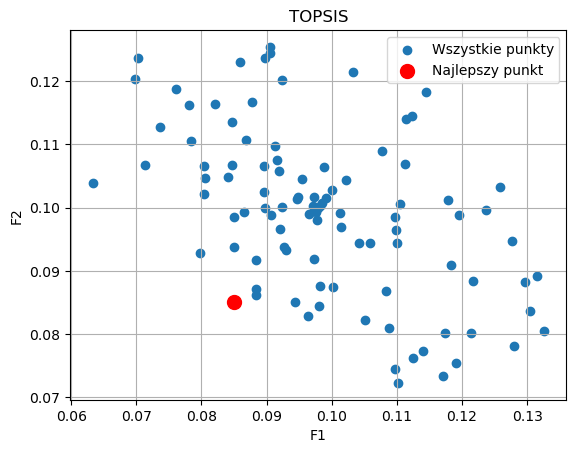

In [16]:
# Generowanie punktów
data = generate_elliptical_points(center=(5, 10), axes=(2, 3), num_points=100, angle=30)

# Normalizacja
m = len(data) # Liczba punktów
n = len(data[0]) # Liczba kryteriów
divisors = np.empty(n)
for j in range(n):
    column = data[:,j]
    divisors[j] = np.sqrt(column @ column)
data /= divisors



# Wyznaczanie najlepszego i najgorszego możliwego punktu
a_pos = np.zeros(n)
a_neg = np.zeros(n)
for j in range(n):
    column = data[:,j]
    a_pos[j] = np.min(column) # Minimalizujemy więc im mniej tym lepiej
    a_neg[j] = np.max(column)

print(f"Najlepszy możliwy punkt: {a_pos}")
print(f"Najgorszy możliwy punkt: {a_neg}")

# Wyznaczanie dystansów i rankingu
cs = np.zeros(m)
for i in range(m):
    diff_pos = data[i] - a_pos
    diff_neg = data[i] - a_neg
    sp = np.sqrt(diff_pos @ diff_pos)
    sn = np.sqrt(diff_neg @ diff_neg)
    cs[i] = sn / (sp + sn)

cs_best = max(cs)
best_point_index = list(cs).index(cs_best)
best_point = data[best_point_index]

print(f"Najlepszy punkt zbioru: {best_point}, Ranking: {cs_best}")

plt.scatter(data[:, 0], data[:, 1], label="Wszystkie punkty")
plt.scatter(best_point[0], best_point[1], color='red', label="Najlepszy punkt", s=100)

plt.title("TOPSIS")
plt.xlabel("F1")
plt.ylabel("F2")
plt.legend()
plt.grid()

In [10]:
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from sklearn.decomposition import PCA

class FuzzyNumber:
    def __init__(self, l, m, u):
        self.l = l  # Dolna granica
        self.m = m  # Modalna
        self.u = u  # Górna granica

    def __repr__(self):
        return f"({self.l}, {self.m}, {self.u})"
    
    def distance(self, other) -> float:
        return np.sqrt(1/3 * ((self.l - other.l)**2 + (self.m - other.m)**2 + (self.u - other.u)**2))
     
    def normalize(self, divisor, w):
        return FuzzyNumber(self.l * w / divisor, self.m * w / divisor, self.u * w / divisor)

def objectives(u, p1=1, p2=1, p3=1, p4=1):
    x, y, z, w = u
    f1_med = x**2 + y**2 + z**2 + w**2
    f2_med = (x - p1)**2 + (y + p2)**2 + (z - p3)**2 + (w + p4)**2
    f3_med = (x + p1)**2 + (y - p2)**2 + (z + p3)**2 + (w - p4)**2
    f4_med = (x - p1)**2 + (y - p2)**2 + (z + p3)**2 + (w + p4)**2
    return [
        FuzzyNumber(f1_med - 2, f1_med, f1_med + 2),
        FuzzyNumber(f2_med - 2, f2_med, f2_med + 2),
        FuzzyNumber(f3_med - 2, f3_med, f3_med + 2),
        FuzzyNumber(f4_med - 2, f4_med, f4_med + 2),
    ]

def normalize_with_weights(data, w):
    normalized_data = []
    for i in range(len(data[0])):
        column = [np.sqrt(f.l**2 + f.m**2 + f.u**2) for f in [row[i] for row in data]]
        divisor = max(column)
        normalized_data.append([row[i].normalize(divisor, w[i]) for row in data])
    return list(map(list, zip(*normalized_data)))

# Funkcja generująca dane w 4 wymiarach
def generate_elliptical_points_4d(center, axes, num_points, angles):
    theta = np.random.uniform(0, 2 * np.pi, num_points)
    r = np.random.uniform(0, 1, num_points)

    # Generowanie punktów dla każdej osi
    x = axes[0] * r * np.cos(theta)
    y = axes[1] * r * np.sin(theta)
    z = axes[2] * r * np.cos(theta)
    w = axes[3] * r * np.sin(theta)

    # Rotacja i przesunięcie w każdej osi
    angle_rad = [np.radians(a) for a in angles]
    x_rot = x * np.cos(angle_rad[0]) - y * np.sin(angle_rad[0])
    y_rot = x * np.sin(angle_rad[0]) + y * np.cos(angle_rad[0])
    z_rot = z * np.cos(angle_rad[1]) - w * np.sin(angle_rad[1])
    w_rot = z * np.sin(angle_rad[1]) + w * np.cos(angle_rad[1])

    # Translacja do centrum
    x_final = x_rot + center[0]
    y_final = y_rot + center[1]
    z_final = z_rot + center[2]
    w_final = w_rot + center[3]

    return np.column_stack((x_final, y_final, z_final, w_final))

# Generowanie danych wejściowych
data = generate_elliptical_points_4d(center=(5, 10, 15, 20), axes=(2, 3, 4, 5), num_points=1000, angles=(30, 45))

# Obliczanie celów
objectives_data = [objectives(p) for p in data]
weights = np.array([0.1, 0.3, 0.5, 0.1])

# Normalizacja danych
normalized_data = normalize_with_weights(objectives_data, weights)

# Wyznaczanie najlepszego i najgorszego punktu
a_pos = [FuzzyNumber(min([fn.l for fn in col]), min([fn.m for fn in col]), min([fn.u for fn in col])) for col in zip(*normalized_data)]
a_neg = [FuzzyNumber(max([fn.l for fn in col]), max([fn.m for fn in col]), max([fn.u for fn in col])) for col in zip(*normalized_data)]

# Wyznaczanie odległości i rankingu
cs = []
for row in normalized_data:
    sp = np.sqrt(sum([f.distance(a_pos[i])**2 for i, f in enumerate(row)]))
    sn = np.sqrt(sum([f.distance(a_neg[i])**2 for i, f in enumerate(row)]))
    cs.append(sn / (sp + sn))

# Ranking punktów
ranking_indices = np.argsort(-np.array(cs))
ranked_data = [data[i] for i in ranking_indices]
ranked_scores = [cs[i] for i in ranking_indices]

print(f"Najlepszy punkt: {ranked_data[0]} (Score: {ranked_scores[0]:.4f})")
print(f"Najgorszy punkt: {ranked_data[-1]} (Score: {ranked_scores[-1]:.4f})")

# Redukcja wymiarów dla wizualizacji
pca = PCA(n_components=3)
reduced_data = pca.fit_transform([[f.m for f in row] for row in normalized_data])

# Najlepszy punkt po redukcji wymiarów
best_point_reduced = reduced_data[ranking_indices[0]]
colors = [row[0].u for row in normalized_data]

# Tworzenie wykresu 3D
scatter = go.Scatter3d(
    x=reduced_data[:, 0],
    y=reduced_data[:, 1],
    z=reduced_data[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, colorscale='Viridis', showscale=True),
    name='Punkty'
)

# Dodanie najlepszego punktu
best_point_marker = go.Scatter3d(
    x=[best_point_reduced[0]],
    y=[best_point_reduced[1]],
    z=[best_point_reduced[2]],
    mode='markers+text',
    marker=dict(size=10, color='red', symbol='diamond'),
    name='Najlepszy punkt',
    text=["Najlepszy punkt"],
    textposition='top center'
)

# Layout wykresu
layout = go.Layout(
    title="TOPSIS Dyskretny (4D, wizualizacja w 3D)",
    scene=dict(
        xaxis_title='Komponent 1',
        yaxis_title='Komponent 2',
        zaxis_title='Komponent 3'
    )
)

# Rysowanie wykresu
fig = go.Figure(data=[scatter, best_point_marker], layout=layout)
fig.show(renderer="browser")


Najlepszy punkt: [ 3.85795361  8.21475861 13.48802533 16.18983118] (Score: 1.0000)
Najgorszy punkt: [ 5.88649172 12.02207589 15.97414746 24.05695208] (Score: 0.0046)


# RSM – wariant dyskretny: Przykłady obliczeń z N=3 i N=4

0 3.7211708735144873 0.7183423351289329 0.8381934456844568 [ 1.74458594 13.05526055]
1 1.6711300292847442 0.834065925028523 0.6670655947721423 [ 4.23949854 10.14507596]
2 2.3673988075674472 0.3036823662680643 0.8863073240743206 [ 3.35167589 10.32426997]
3 4.187358276518513 1.26126572766545 0.7685166517827379 [8.59356691 6.64935386]
4 3.109053158341599 0.29026108663187794 0.9146118700084632 [6.16607913 7.65834738]
5 2.0976428336269595 0.48834134456363726 0.8111584174867892 [4.24089481 9.43075722]
6 2.447044561980476 1.4321869864147658 0.6308065222331901 [ 2.85939257 12.21402874]
7 2.4223326248846773 0.48673180016925605 0.83268442046957 [5.48464534 8.36157262]
8 3.604378931396454 0.31650892001844916 0.9192762119160759 [6.69082175 7.24371312]
9 3.7419605467658688 0.3996236811301891 0.9035094642193963 [6.81673572 7.13319284]
10 2.4831937685967542 0.022826971917255925 0.9908911480466942 [4.84526498 8.49091911]
11 2.868261940050091 1.556953788968033 0.6481631892523593 [ 2.65085911 13.0476284

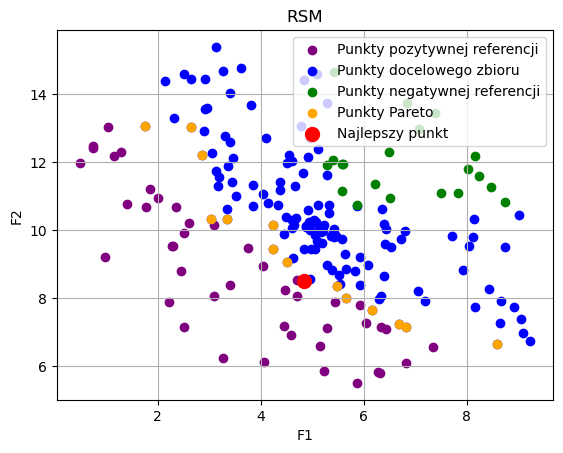

In [55]:
def pareto_front(points):
    points = np.array(points)
    is_pareto = np.ones(points.shape[0], dtype=bool)  # Initialize all as True

    for i, point in enumerate(points):
        if is_pareto[i]:
            # If `point` is Pareto optimal, mark dominated points
            is_pareto[is_pareto] = ~np.all(points[is_pareto] >= point, axis=1) | np.all(points[is_pareto] == point, axis=1)
            is_pareto[i] = True  # Keep the current point as Pareto optimal

    return points[is_pareto]

# Generowanie punktów
all_data = generate_elliptical_points(center=(5, 10), axes=(4, 6), num_points=200, angle=30)
all_data = list(all_data)

positive_reference = []
for i in range(4):
    par = pareto_front(all_data)
    for p in par:
        positive_reference.append(p)
        all_data = [el for el in all_data if set(el) != set(p)]

data = []
for i in range(10):
    par = pareto_front(all_data)
    for p in par:
        data.append(p)
        all_data = [el for el in all_data if set(el) != set(p)]
       

positive_reference = np.array(positive_reference)
data = np.array(data)
negative_reference = np.array(all_data)
pareto = pareto_front(data)

# Właściwy algorytm
cs = np.zeros(len(pareto))
for i, p in enumerate(pareto):
    min_dist = np.inf
    for pr in positive_reference:
        diff_pos = p - pr
        dist = np.sqrt(diff_pos @ diff_pos)
        if dist < min_dist:
            min_dist = dist
    sp = min_dist

    min_dist = np.inf
    for nr in negative_reference:
        diff_neg = p - nr
        dist = np.sqrt(diff_neg @ diff_neg)
        if dist < min_dist:
            min_dist = dist
    sn = min_dist

    cs[i] = sn / (sp + sn)
    print(i, sn, sp, cs[i], p)
    
cs_best = max(cs)
best_point_index = list(cs).index(cs_best)
print(best_point_index)
best_point = data[best_point_index]
        
plt.scatter(positive_reference[:, 0], positive_reference[:, 1], color='purple', label="Punkty pozytywnej referencji")
plt.scatter(data[:, 0], data[:, 1], color='blue', label="Punkty docelowego zbioru")
plt.scatter(negative_reference[:, 0], negative_reference[:, 1], color='green', label="Punkty negatywnej referencji")
plt.scatter(pareto[:, 0], pareto[:, 1], color='orange', label="Punkty Pareto")
plt.scatter(best_point[0], best_point[1], color='red', label="Najlepszy punkt", s=100)

plt.title("RSM")
plt.xlabel("F1")
plt.ylabel("F2")
plt.legend()
plt.grid()

In [ ]:
import numpy as np
import plotly.graph_objects as go

# Funkcja generująca front Pareto
def pareto_front(points):
    points = np.array(points)
    is_pareto = np.ones(points.shape[0], dtype=bool)  # Wszystkie punkty są kandydatami

    for i, point in enumerate(points):
        if is_pareto[i]:
            # Punkt `point` jest Pareto optymalny, usuwamy punkty zdominowane
            is_pareto[is_pareto] = ~np.all(points[is_pareto] <= point, axis=1) | np.all(points[is_pareto] == point, axis=1)
            is_pareto[i] = True  # Punkt pozostaje optymalny

    return points[is_pareto]

# Generowanie punktów w 4 wymiarach
def generate_elliptical_points_4d(center, axes, num_points, angle=30):
    theta = np.random.uniform(0, 2 * np.pi, num_points)
    phi = np.random.uniform(0, np.pi, num_points)
    r = np.random.uniform(0, 1, num_points)

    # Przekształcenie do przestrzeni elipsoidalnej
    x = axes[0] * r * np.sin(phi) * np.cos(theta)
    y = axes[1] * r * np.sin(phi) * np.sin(theta)
    z = axes[2] * r * np.cos(phi)
    w = axes[3] * r

    # Rotacja w przestrzeni 2D (x-y)
    angle_rad = np.radians(angle)
    x_rot = x * np.cos(angle_rad) - y * np.sin(angle_rad)
    y_rot = x * np.sin(angle_rad) + y * np.cos(angle_rad)

    # Translacja do środka elipsy
    x_final = x_rot + center[0]
    y_final = y_rot + center[1]
    z_final = z + center[2]
    w_final = w + center[3]

    return np.column_stack((x_final, y_final, z_final, w_final))

# Generowanie danych
all_data = generate_elliptical_points_4d(center=(5, 10, 15, 20), axes=(4, 6, 8, 2), num_points=2000, angle=30)

# Wyznaczanie punktów referencji
positive_reference = []
all_data_list = list(all_data)
for _ in range(2):  
    par = pareto_front(all_data_list)
    for p in par:
        positive_reference.append(p)
        all_data = [el for el in all_data if set(el) != set(p)]
data = []
for _ in range(4):  
    par = pareto_front(all_data_list)
    for p in par:
        data.append(p)
        all_data_list = [el for el in all_data_list if set(el) != set(p)]
        # print(len(all_data_list))

data = np.array(data)
negative_reference = np.array(all_data_list)
pareto = pareto_front(data)

# Algorytm RSM
cs = np.zeros(len(pareto))
for i, p in enumerate(pareto):
    # Odległości do punktów referencji pozytywnych
    sp = min(np.linalg.norm(p - pr, ord=np.inf) for pr in positive_reference)
    # Odległości do punktów referencji negatywnych
    sn = min(np.linalg.norm(p - nr, ord=np.inf) for nr in negative_reference)
    # Ranking
    cs[i] = sn / (sp + sn)
    # print(i, sn, sp, cs[i], p)

# Najlepszy punkt
cs_best = max(cs)
best_point_index = list(cs).index(cs_best)
best_point = pareto[best_point_index]
positive_reference=np.array(positive_reference)

# Przygotowanie wykresu interaktywnego za pomocą plotly
fig = go.Figure()

# Dodanie punktów do wykresu
fig.add_trace(go.Scatter3d(x=positive_reference[:, 0], y=positive_reference[:, 1], z=positive_reference[:, 2],
                           mode='markers', marker=dict(size=5, color='purple'), name="Punkty pozytywnej referencji"))
fig.add_trace(go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2],
                           mode='markers', marker=dict(size=5, color='blue'), name="Punkty docelowego zbioru"))
fig.add_trace(go.Scatter3d(x=negative_reference[:, 0], y=negative_reference[:, 1], z=negative_reference[:, 2],
                           mode='markers', marker=dict(size=5, color='green'), name="Punkty negatywnej referencji"))
fig.add_trace(go.Scatter3d(x=pareto[:, 0], y=pareto[:, 1], z=pareto[:, 2],
                           mode='markers', marker=dict(size=5, color=pareto[:, 3], colorscale='Viridis'),
                           name="Punkty Pareto (kolor=F4)"))
fig.add_trace(go.Scatter3d(x=[best_point[0]], y=[best_point[1]], z=[best_point[2]],
                           mode='markers', marker=dict(size=10, color='red'), name="Najlepszy punkt"))

# Oznaczenia i legenda
fig.update_layout(title="RSM (3D z kolorem reprezentującym 4. wymiar)",
                  scene=dict(xaxis_title="F1", yaxis_title="F2", zaxis_title="F3"),
                  legend=dict(yanchor="top", y=0.9, xanchor="left", x=0.1))

# Wyświetlenie wykresu
fig.show(renderer="browser")


# UTA - wariant sortujący

In [ ]:
import numpy as np
import plotly.graph_objects as go

import numpy as np

# Funkcja definiująca zbiór niezdominowanych punktów
def pareto_front(points):
    points = np.array(points)
    is_pareto = np.ones(points.shape[0], dtype=bool)
    
    for i, point in enumerate(points):
        if is_pareto[i]:
            is_pareto[is_pareto] = ~np.all(points[is_pareto] <= point, axis=1) | np.all(points[is_pareto] == point, axis=1)
            is_pareto[i] = True
    return points[is_pareto]

# Funkcja klasyfikująca punkty referencyjne do FP(A*, θ) i FP(A*, -θ)
def classify_reference_points(A_star, theta):
    A_star = np.array(A_star)
    positive_reference = pareto_front(A_star + theta)
    negative_reference = pareto_front(A_star - theta)
    return positive_reference, negative_reference

# Funkcja wyznaczania użyteczności z uwzględnieniem wag kryteriów
def utility_function(point, positive_reference, negative_reference, lambda_, weights):
    # Odległości do punktów pozytywnych i negatywnych z uwzględnieniem wag
    sp = sum(weights[i] * min(abs(point[i] - pr[i]) for pr in positive_reference) for i in range(len(point)))
    sn = sum(weights[i] * min(abs(point[i] - nr[i]) for nr in negative_reference) for i in range(len(point)))
    
    # Normalizacja
    sp_sn_sum = sp + sn or 1e-9  # Zapobieganie dzieleniu przez zero
    utility = lambda_ * sp / sp_sn_sum + (1 - lambda_) * sn / sp_sn_sum
    return utility

def uta_discrete(points, A_star, theta, lambda_=0.5, weights=None):
    points = np.array(points)
    A_star = np.array(A_star)
    theta = np.array(theta)

    # Domyślne wagi, jeśli nie zostały podane
    if weights is None:
        weights = np.ones(points.shape[1]) / points.shape[1]  # Równomierne wagi dla każdego kryterium

    # Klasyfikacja punktów referencyjnych
    positive_reference, negative_reference = classify_reference_points(A_star, theta)

    # Obliczanie funkcji użyteczności dla każdego punktu
    utilities = [utility_function(point, positive_reference, negative_reference, lambda_, weights) for point in points]
    
    # Ranking punktów na podstawie funkcji użyteczności
    ranking = sorted(zip(points, utilities), key=lambda x: x[1], reverse=True)
    return ranking

# Generowanie punktów w 4 wymiarach
def generate_elliptical_points_4d(center, axes, num_points, angle=30):
    theta = np.random.uniform(0, 2 * np.pi, num_points)
    phi = np.random.uniform(0, np.pi, num_points)
    r = np.random.uniform(0, 1, num_points)

    # Przekształcenie do przestrzeni elipsoidalnej
    x = axes[0] * r * np.sin(phi) * np.cos(theta)
    y = axes[1] * r * np.sin(phi) * np.sin(theta)
    z = axes[2] * r * np.cos(phi)
    w = axes[3] * r

    # Rotacja w przestrzeni 2D (x-y)
    angle_rad = np.radians(angle)
    x_rot = x * np.cos(angle_rad) - y * np.sin(angle_rad)
    y_rot = x * np.sin(angle_rad) + y * np.cos(angle_rad)

    # Translacja do środka elipsy
    x_final = x_rot + center[0]
    y_final = y_rot + center[1]
    z_final = z + center[2]
    w_final = w + center[3]

    return np.column_stack((x_final, y_final, z_final, w_final))

# Przykładowe dane
np.random.seed(42)
center = [5, 5, 5, 5]
axes = [2, 3, 1.5, 2]  # Rozmiar osi elipsoidy
num_points = 100

# Generowanie punktów decyzyjnych i referencyjnych
points = generate_elliptical_points_4d(center, axes, num_points)
A_star = generate_elliptical_points_4d(center, axes, 10)
theta = np.array([0.5, 0.5, 0.5, 0.5])  # Stożek preferencji
lambda_ = 0.7  # Parametr preferencji
weights = np.array([0.4, 0.3, 0.2, 0.1])  # Wagi kryteriów

# Wywołanie algorytmu UTA-D
ranking = uta_discrete(points, A_star, theta, lambda_=lambda_, weights=weights)



# Funkcja do generowania interaktywnego wykresu 4D
def plot_4d_with_best(points, utilities, title="Ranking punktów w algorytmie UTA"):
    # Ekstrakcja współrzędnych i funkcji użyteczności
    x, y, z, c = points[:, 0], points[:, 1], points[:, 2], points[:, 3]
    
    # Normalizacja funkcji użyteczności do zakresu [0, 1] dla kolorów
    normalized_utilities = (utilities - np.min(utilities)) / (np.max(utilities) - np.min(utilities))
    
    # Znalezienie najlepszego punktu (najwyższa wartość funkcji użyteczności)
    best_idx = np.argmax(utilities)
    best_point = points[best_idx]
    best_utility = utilities[best_idx]
    
    # Tworzenie wykresu 3D z kolorem odpowiadającym czwartemu wymiarowi
    fig = go.Figure()
    
    # Wszystkie punkty
    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=6,
            color=normalized_utilities,  # Kolor odpowiada funkcji użyteczności
            colorscale='Viridis',  # Skala kolorów
            showscale=True,  # Pokaż skalę kolorów
            colorbar=dict(title="Funkcja<br>użyteczności")
        ),
        text=[f"u4={ci:.2f}, U={ui:.4f}" for ci, ui in zip(c, utilities)],  # Etykiety
        name="Punkty"
    ))
    
    # Najlepszy punkt
    fig.add_trace(go.Scatter3d(
        x=[best_point[0]],
        y=[best_point[1]],
        z=[best_point[2]],
        mode='markers+text',
        marker=dict(
            size=10,
            color='red',  # Wyróżnienie kolorem
            symbol='diamond'  # Symbol diamentu
        ),
        text=[f"Najlepszy punkt<br>u4={best_point[3]:.2f}, U={best_utility:.4f}"],
        textposition="top center",
        name="Najlepszy punkt"
    ))
    
    # Ustawienia wykresu
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title="Kryterium 1",
            yaxis_title="Kryterium 2",
            zaxis_title="Kryterium 3",
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )
    
    fig.show(renderer="browser")

# Przykładowe dane do wizualizacji
points_array = np.array([point for point, _ in ranking])
utilities_array = np.array([utility for _, utility in ranking])


plot_4d_with_best(points_array, utilities_array)



# UTA - wariant sortujący wersja ciągła

In [9]:
import numpy as np
import plotly.graph_objects as go

# Funkcja definiująca zbiór niezdominowanych punktów
def pareto_front(points):
    points = np.array(points)
    is_pareto = np.ones(points.shape[0], dtype=bool)
    
    for i, point in enumerate(points):
        if is_pareto[i]:
            is_pareto[is_pareto] = ~np.all(points[is_pareto] <= point, axis=1) | np.all(points[is_pareto] == point, axis=1)
            is_pareto[i] = True
    return points[is_pareto]

# Funkcja klasyfikująca punkty referencyjne do FP(A*, θ) i FP(A*, -θ)
def classify_reference_points(A_star, theta):
    A_star = np.array(A_star)
    positive_reference = pareto_front(A_star + theta)
    negative_reference = pareto_front(A_star - theta)
    return positive_reference, negative_reference

# Funkcja wyznaczania użyteczności z uwzględnieniem wag kryteriów
def utility_function(point, positive_reference, negative_reference, lambda_, weights):
    sp = sum(weights[i] * min(abs(point[i] - pr[i]) for pr in positive_reference) for i in range(len(point)))
    sn = sum(weights[i] * min(abs(point[i] - nr[i]) for nr in negative_reference) for i in range(len(point)))
    sp_sn_sum = sp + sn or 1e-9  # Zapobieganie dzieleniu przez zero
    utility = lambda_ * sp / sp_sn_sum + (1 - lambda_) * sn / sp_sn_sum
    return utility

# Funkcja ciągła
def uta_continuous(points, A_star, theta, lambda_=0.5, weights=None):
    points = np.array(points)
    A_star = np.array(A_star)
    theta = np.array(theta)
    if weights is None:
        weights = np.ones(points.shape[1]) / points.shape[1]  # Równomierne wagi dla każdego kryterium

    positive_reference, negative_reference = classify_reference_points(A_star, theta)
    utilities = np.array([utility_function(point, positive_reference, negative_reference, lambda_, weights) for point in points])
    return utilities

# Funkcja wielokryterialna (ciągła)
def objectives(u, p1=1, p2=1, p3=1, p4=1):
    x, y, z, w = u
    f1 = x**2 + y**2 + z**2 + w**2
    f2 = (x - p1)**2 + (y + p2)**2 + (z - p3)**2 + (w + p4)**2
    f3 = (x + p1)**2 + (y - p2)**2 + (z + p3)**2 + (w - p4)**2
    f4 = (x - p1)**2 + (y - p2)**2 + (z + p3)**2 + (w + p4)**2
    return [f1, f2, f3, f4]

# Generowanie siatki danych
x_vals = np.linspace(-10, 10, 10)
y_vals = np.linspace(-1, 1, 10)
z_vals = np.linspace(-5, 5, 10)
w_vals = np.linspace(0, 20, 10)

X, Y, Z, W = np.meshgrid(x_vals, y_vals, z_vals, w_vals)
U_grid = np.column_stack([X.ravel(), Y.ravel(), Z.ravel(), W.ravel()])

# Generowanie funkcji celu
all_data = np.array([objectives(p) for p in U_grid])

# Obliczanie użyteczności
A_star_before = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [1, 2, 3, 4]])
A_star = np.array([objectives(p) for p in A_star_before])
theta = np.array([0.5, 0.5, 0.5, 0.5])
lambda_ = 0.7
weights = np.array([0.4, 0.3, 0.2, 0.1])

utilities = uta_continuous(all_data, A_star, theta, lambda_, weights)

# Funkcja do generowania interaktywnego wykresu 4D
def plot_4d_with_best(points, utilities, title="Ranking punktów w algorytmie UTA"):
    # Ekstrakcja współrzędnych i funkcji użyteczności
    x, y, z, c = points[:, 0], points[:, 1], points[:, 2], points[:, 3]
    
    # Normalizacja funkcji użyteczności do zakresu [0, 1] dla kolorów
    normalized_utilities = (utilities - np.min(utilities)) / (np.max(utilities) - np.min(utilities))
    
    # Znalezienie najlepszego punktu (najwyższa wartość funkcji użyteczności)
    best_idx = np.argmax(utilities)
    best_point = points[best_idx]
    best_utility = utilities[best_idx]
    
    # Tworzenie wykresu 3D z kolorem odpowiadającym czwartemu wymiarowi
    fig = go.Figure()
    
    # Wszystkie punkty
    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=6,
            color=normalized_utilities,  # Kolor odpowiada funkcji użyteczności
            colorscale='Viridis',  # Skala kolorów
            showscale=True,  # Pokaż skalę kolorów
            colorbar=dict(title="Funkcja<br>użyteczności")
        ),
        text=[f"u4={ci:.2f}, U={ui:.4f}" for ci, ui in zip(c, utilities)],  # Etykiety
        name="Punkty"
    ))
    
    # Najlepszy punkt
    fig.add_trace(go.Scatter3d(
        x=[best_point[0]],
        y=[best_point[1]],
        z=[best_point[2]],
        mode='markers+text',
        marker=dict(
            size=10,
            color='red',  # Wyróżnienie kolorem
            symbol='diamond'  # Symbol diamentu
        ),
        text=[f"Najlepszy punkt<br>u4={best_point[3]:.2f}, U={best_utility:.4f}"],
        textposition="top center",
        name="Najlepszy punkt"
    ))
    
    # Ustawienia wykresu
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title="Kryterium 1",
            yaxis_title="Kryterium 2",
            zaxis_title="Kryterium 3",
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )
    
    fig.show(renderer="browser")

# Przykład wizualizacji
plot_4d_with_best(U_grid, utilities)


SP-CS

C:\Users\Piotr Mamos\AppData\Local\Temp\ipykernel_22652\507766.py:43: RuntimeWarning:

invalid value encountered in divide

C:\Users\Piotr Mamos\AppData\Local\Temp\ipykernel_22652\507766.py:37: RuntimeWarning:

invalid value encountered in divide



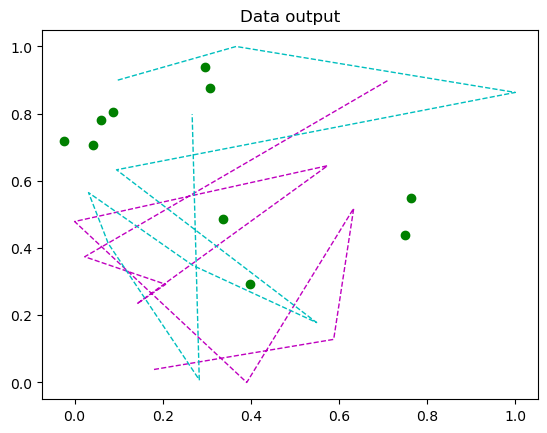

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(n_points, n_features):
   # Funkcja wielokryterialna (ciągła)
    def objectives(u, p1=1, p2=1, p3=1, p4=1):
        x, y, z, w = u
        f1 = x**2 + y**2 + z**2 + w**2
        f2 = (x - p1)**2 + (y + p2)**2 + (z - p3)**2 + (w + p4)**2
        f3 = (x + p1)**2 + (y - p2)**2 + (z + p3)**2 + (w - p4)**2
        f4 = (x - p1)**2 + (y - p2)**2 + (z + p3)**2 + (w + p4)**2
        return [f1, f2, f3, f4]

    # Generowanie siatki danych
    x_vals = np.linspace(-10, 10, 10)
    y_vals = np.linspace(-1, 1, 10)
    z_vals = np.linspace(-5, 5, 10)
    w_vals = np.linspace(0, 20, 10)

    X, Y, Z, W = np.meshgrid(x_vals, y_vals, z_vals, w_vals)
    U_grid = np.column_stack([X.ravel(), Y.ravel(), Z.ravel(), W.ravel()])

    # Generowanie funkcji celu
    all_data = np.array([objectives(p) for p in U_grid])
    return all_data

def normalize_matrix(A0, A1, Fu):
    # Normalizacja danych
    def normalize(A, min_el, max_el):
        return (A - min_el) / (max_el - min_el) if max_el - min_el != 0 else A
    A0_norm, A1_norm, Fu_norm = [], [], []
    
    for i in range(A0.shape[1]):
        max_el = max(np.max(np.abs(A0[:, i])), np.max(np.abs(A1[:, i])))
        min_el = min(np.min(np.abs(A0[:, i])), np.min(np.abs(A1[:, i])))
        
        A0_norm.append(normalize(A0[:, i], min_el, max_el))
        A1_norm.append(normalize(A1[:, i], min_el, max_el))
        Fu_norm.append(normalize(Fu[:, i], min_el, max_el))
    
    return np.array(A0_norm).T, np.array(A1_norm).T, np.array(Fu_norm).T

def scoring_function(w_points, A):
    scoring = []
    for i in range(1, w_points.shape[0]):
        temp, np = point_to_line(w_points[i-1, :], w_points[i, :], A)
        d = [temp]
        d.extend(np.T)
        scoring.append(d[0] + m_line_length_to_point(w_points, np.T))
    return min(scoring)

def nearest_point(v1, v2, pt):
    # Funkcja do obliczania najbliższego punktu na linii
    n = v2 - v1
    n = n / np.linalg.norm(n)
    return pt + ((v1 - pt) - np.dot((v1 - pt), n) * n)

def point_to_line(v1, v2, pt):
    # Funkcja oblicza odległość od punktu do linii
    n = v2 - v1
    n = n / np.linalg.norm(n)
    check_point = nearest_point(v1, v2, pt)
    return np.linalg.norm((v1 - pt) - np.dot((v1 - pt), n) * n), check_point

def m_line_length_to_point(w_points, A):
    # Zwraca znormalizowaną odległość od początku łamanej do punktu A
    distance = 0
    for i in range(1, w_points.shape[0]):
        if point_on_the_line(w_points[i-1, :], w_points[i, :], A):
            distance += np.linalg.norm(w_points[i-1, :] - A)
    return distance / m_line_length(w_points)

def point_on_the_line(L, U, A):
    # Sprawdzamy, czy punkt A leży na odcinku L-U
    l1 = np.linalg.norm(L - A)
    l2 = np.linalg.norm(U - A)
    l3 = np.linalg.norm(U - L)
    return 1 if np.isclose(l1 + l2, l3) else -1

def m_line_length(w_points):
    # Zwraca długość krzywej łamanej
    length = 0
    for i in range(1, w_points.shape[0]):
        length += np.linalg.norm(w_points[i, :] - w_points[i-1, :])
    return length

def plot_sets(A0_norm, A1_norm):
    # Rysowanie zbiorów
    plt.plot(A0_norm[:, 0], A0_norm[:, 1], 'm--', linewidth=1)
    plt.plot(A1_norm[:, 0], A1_norm[:, 1], 'c--', linewidth=1)

def plot_points(Fu_norm):
    # Rysowanie punktów
    plt.scatter(Fu_norm[:, 0], Fu_norm[:, 1], color='green')

def SP_CS(A0, A1, Fu):
    # Główna funkcja algorytmu
    A0_norm, A1_norm, Fu_norm = normalize_matrix(A0, A1, Fu)
    
    scoring_vector = [-1] * Fu_norm.shape[0]
    
    for i in range(A1.shape[0]):
        for j in range(A1.shape[0]):
            w_points = sketch_line(A0_norm[i, :], A1_norm[j, :])
            for k in range(Fu_norm.shape[0]):
                score = scoring_function(w_points, Fu_norm[k, :])
                if score < scoring_vector[k]:
                    scoring_vector[k] = score
                elif scoring_vector[k] == -1:
                    scoring_vector[k] = score
    
    scoring_vector = sorted(range(len(scoring_vector)), key=lambda k: scoring_vector[k])
    
    plt.title("Data output")
    plot_sets(A0_norm, A1_norm)
    plot_points(Fu_norm)
    plt.show()

def sketch_line(L, U):
    # Funkcja tworzy linię łamaną
    w_points = np.array([L])
    for i in range(L.shape[0] - 1):
        w_points = np.vstack([w_points, L + (U - L) * (i / (L.shape[0] - 1))])
    return w_points

# Generowanie danych
n_points = 10  # Liczba punktów
n_features = 4  # Liczba cech (wymiarowość)
A0 = generate_data(n_points, n_features)
A1 = generate_data(n_points, n_features)
Fu = generate_data(n_points, n_features)

# Uruchomienie algorytmu
SP_CS(A0, A1, Fu)


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def objectives(u, p1=1, p2=1, p3=1, p4=1):
    # Funkcja wielokryterialna (ciągła)
    x, y, z, w = u
    f1 = x**2 + y**2 + z**2 + w**2
    f2 = (x - p1)**2 + (y + p2)**2 + (z - p3)**2 + (w + p4)**2
    f3 = (x + p1)**2 + (y - p2)**2 + (z + p3)**2 + (w - p4)**2
    f4 = (x - p1)**2 + (y - p2)**2 + (z + p3)**2 + (w + p4)**2
    return [f1, f2, f3, f4]

def generate_data_using_objectives(n_points, n_features):
    # Generowanie siatki danych
    x_vals = np.linspace(-10, 10, n_points)
    y_vals = np.linspace(-1, 1, n_points)
    z_vals = np.linspace(-5, 5, n_points)
    w_vals = np.linspace(0, 20, n_points)

    X, Y, Z, W = np.meshgrid(x_vals, y_vals, z_vals, w_vals)
    U_grid = np.column_stack([X.ravel(), Y.ravel(), Z.ravel(), W.ravel()])

    # Generowanie funkcji celu
    all_data = np.array([objectives(p) for p in U_grid])
    return all_data

def normalize_matrix(A0, A1, Fu):
    # Normalizacja danych
    def normalize(A, min_el, max_el):
        return (A - min_el) / (max_el - min_el) if max_el - min_el != 0 else A
    A0_norm, A1_norm, Fu_norm = [], [], []
    
    for i in range(A0.shape[1]):
        max_el = max(np.max(np.abs(A0[:, i])), np.max(np.abs(A1[:, i])))
        min_el = min(np.min(np.abs(A0[:, i])), np.min(np.abs(A1[:, i])))
        
        A0_norm.append(normalize(A0[:, i], min_el, max_el))
        A1_norm.append(normalize(A1[:, i], min_el, max_el))
        Fu_norm.append(normalize(Fu[:, i], min_el, max_el))
    
    return np.array(A0_norm).T, np.array(A1_norm).T, np.array(Fu_norm).T

def scoring_function(w_points, A):
    scoring = []
    for i in range(1, w_points.shape[0]):
        temp, np = point_to_line(w_points[i-1, :], w_points[i, :], A)
        d = [temp]
        d.extend(np.T)
        scoring.append(d[0] + m_line_length_to_point(w_points, np.T))
    return min(scoring)

def nearest_point(v1, v2, pt):
    # Funkcja do obliczania najbliższego punktu na linii
    n = v2 - v1
    n = n / np.linalg.norm(n)
    return pt + ((v1 - pt) - np.dot((v1 - pt), n) * n)

def point_to_line(v1, v2, pt):
    # Funkcja oblicza odległość od punktu do linii
    n = v2 - v1
    n = n / np.linalg.norm(n)
    check_point = nearest_point(v1, v2, pt)
    return np.linalg.norm((v1 - pt) - np.dot((v1 - pt), n) * n), check_point

def m_line_length_to_point(w_points, A):
    # Zwraca znormalizowaną odległość od początku łamanej do punktu A
    distance = 0
    for i in range(1, w_points.shape[0]):
        if point_on_the_line(w_points[i-1, :], w_points[i, :], A):
            distance += np.linalg.norm(w_points[i-1, :] - A)
    return distance / m_line_length(w_points)

def point_on_the_line(L, U, A):
    # Sprawdzamy, czy punkt A leży na odcinku L-U
    l1 = np.linalg.norm(L - A)
    l2 = np.linalg.norm(U - A)
    l3 = np.linalg.norm(U - L)
    return 1 if np.isclose(l1 + l2, l3) else -1

def m_line_length(w_points):
    # Zwraca długość krzywej łamanej
    length = 0
    for i in range(1, w_points.shape[0]):
        length += np.linalg.norm(w_points[i, :] - w_points[i-1, :])
    return length

def plot_sets(A0_norm, A1_norm):
    # Rysowanie zbiorów
    plt.plot(A0_norm[:, 0], A0_norm[:, 1], 'm--', linewidth=1)
    plt.plot(A1_norm[:, 0], A1_norm[:, 1], 'c--', linewidth=1)

def plot_points(Fu_norm):
    # Rysowanie punktów
    plt.scatter(Fu_norm[:, 0], Fu_norm[:, 1], color='green')

def SP_CS(A0, A1, Fu):
    # Główna funkcja algorytmu
    A0_norm, A1_norm, Fu_norm = normalize_matrix(A0, A1, Fu)
    
    scoring_vector = [-1] * Fu_norm.shape[0]
    
    for i in range(A1.shape[0]):
        for j in range(A1.shape[0]):
            w_points = sketch_line(A0_norm[i, :], A1_norm[j, :])
            for k in range(Fu_norm.shape[0]):
                score = scoring_function(w_points, Fu_norm[k, :])
                if score < scoring_vector[k]:
                    scoring_vector[k] = score
                elif scoring_vector[k] == -1:
                    scoring_vector[k] = score
    
    scoring_vector = sorted(range(len(scoring_vector)), key=lambda k: scoring_vector[k])
    
    plt.title("Data output")
    plot_sets(A0_norm, A1_norm)
    plot_points(Fu_norm)
    plt.show()

def sketch_line(L, U):
    # Funkcja tworzy linię łamaną
    w_points = np.array([L])
    for i in range(L.shape[0] - 1):
        w_points = np.vstack([w_points, L + (U - L) * (i / (L.shape[0] - 1))])
    return w_points

# Generowanie danych
n_points = 10  # Liczba punktów
n_features = 4  # Liczba cech (wymiarowość 4, dla funkcji wielokryterialnej)
A0 = generate_data_using_objectives(n_points, n_features)
A1 = generate_data_using_objectives(n_points, n_features)
Fu = generate_data_using_objectives(n_points, n_features)

# Uruchomienie algorytmu
SP_CS(A0, A1, Fu)


C:\Users\Piotr Mamos\AppData\Local\Temp\ipykernel_22652\1241918044.py:61: RuntimeWarning:

invalid value encountered in divide

C:\Users\Piotr Mamos\AppData\Local\Temp\ipykernel_22652\1241918044.py:55: RuntimeWarning:

invalid value encountered in divide



KeyboardInterrupt: 